In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import random

# Compilemos el archivo

In [2]:
! cd ../genetico && make main_test

g++ -std=c++11 -pedantic -Wall -O4 -DSHOWSENSEI -DOUTPUTBEST -o main_test main_test.cpp ../common/game.o ../common/board.h ../common/judge_proxy.h ../common/player.h ../common/player_random.h ../common/game.h ../common/players.h ../common/possible_move.h ../common/player_minimax.h ../common/player_minimax_n.h ../common/minimax.h genome.h mating_pool.h gene.h player_genetic.h
In file included from main_test.cpp:2:0:
mating_pool.h: In member function ‘void MatingPool::newGeneration()’:
mating_pool.h:85:9: warning: unused variable ‘fitSize’ [-Wunused-variable]
     int fitSize = fittest.size();
         ^
mating_pool.h: In member function ‘void MatingPool::evolvePopulation(unsigned int, int)’:
mating_pool.h:157:31: warning: comparison between signed and unsigned integer expressions [-Wsign-compare]
             for (int i = 0; i < genome.geneWeights.size(); ++i) {
                               ^
mating_pool.h:159:21: warning: comparison between signed and unsigned integer expressions [-W

In [5]:
#Definimos los parametros que vamos a usar para las experimentaciones

rows = 6 
cols = 7
c = 4
pieces = 21
amountOfSurvivors = 10
populationSize = 25
games = 30
pc = 0.8
pm = 0.05
t = 0.5
mr = 1.0
pRandomMating = 0.01
fitnessFunction = 1
alpha = 0.5
extinctionRate = 50
generations = 25

#Esto es un helper, no lo borro porque porahi sirve mas adelante, pero no se usa.
#callingArgument = str(rows) + ' ' + str(cols) + ' ' + str(c)+ ' ' + str(pieces)+ ' ' + str(amountOfSurvivors)+ ' ' + str(populationSize)+ ' ' + str(games)+ ' ' + str(pc)+ ' ' + str(pm)+ ' ' + str(t)+ ' ' + str(mr)+ ' ' + str(pRandomMating)+ ' ' + str(fitnessFunction)+ ' ' + str(alpha)+ ' ' + str(extinctionRate)+ ' ' + str(generations)

In [6]:
#Definamos una funcion a la que le pasamos un archivo y si queremos info sobre quien fue el rival. 
#Nos va a graficar la media y la varianza

def graphFitness(fileName, moreInfo,rival):
    dfResultados = pd.read_csv(fileName, delimiter=";")
    dfVariance = dfResultados.groupby('Generation').var()
    dfMean = dfResultados.groupby('Generation').mean()

    ax = dfMean.plot(logy=False)
    ax.set_ylabel("Media de la Fitness")
    ax.set_xlabel("Generacion")    
    title = "Media de la Fitness en funcion de la generacion" + ((" contra un rival " + rival) if moreInfo else "")
    plt.title(title)
    plt.show()


    ax = dfVariance.plot(logy=False)
    ax.set_ylabel("Varianza de la Fitness")
    title = "Varianza de la Fitness en funcion de la generacion" + ((" contra un rival " + rival) if moreInfo else "")
    plt.title(title)
    plt.show()

# Versus un rival random

In [5]:
! RIVAL=RANDOM ../genetico/main_test $rows $cols $c $pieces $amountOfSurvivors $populationSize $games $pc $pm $t $mr $pRandomMating $fitnessFunction $alpha $extinctionRate $generations

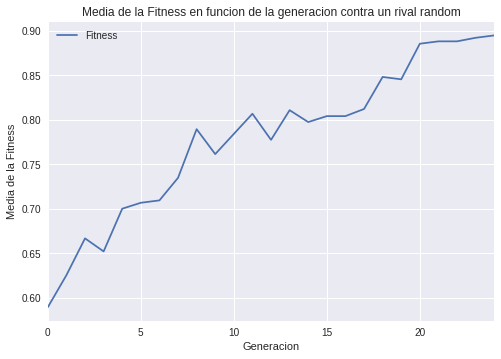

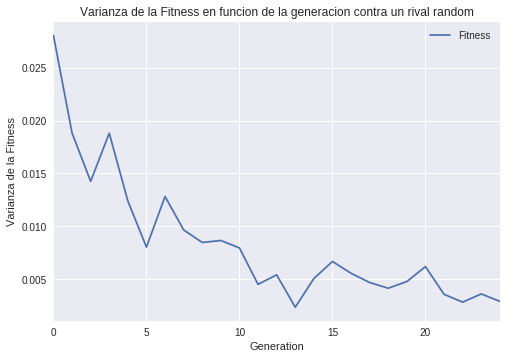

In [6]:
graphFitness('./fitness_RANDOM_population25.txt',True,"random")

# Versus un rival de su propia generacion

In [ ]:
! RIVAL=ANCESTORS ../genetico/main_test $rows $cols $c $pieces $amountOfSurvivors $populationSize $games $pc $pm $t $mr $pRandomMating $fitnessFunction $alpha $extinctionRate $generations

In [ ]:
graphFitness('./fitness_ANCESTORS_population25.txt',True,"ancestral")

# Versus un minimax acotado

In [6]:
! RIVAL=MINIMAX ../genetico/main_test $rows $cols $c $pieces $amountOfSurvivors $populationSize $games $pc $pm $t $mr $pRandomMating $fitnessFunction $alpha $extinctionRate $generations

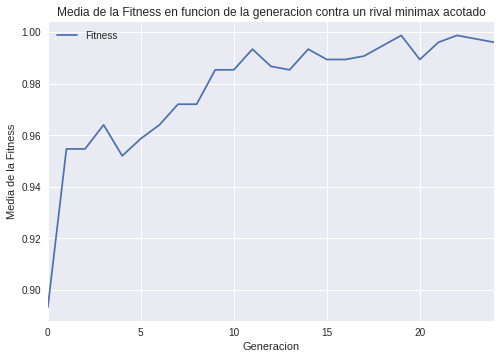

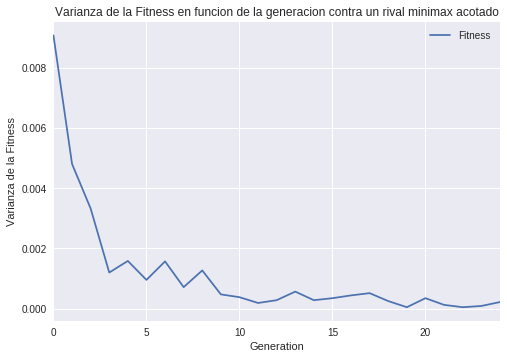

In [7]:
graphFitness('./fitness_MINIMAX_population25.txt',True,"minimax acotado")

# Versus partidos de cada uno: random, ancestors y minimax. Un tercio cada uno

In [7]:
! RIVAL=MIXED ../genetico/main_test $rows $cols $c $pieces $amountOfSurvivors $populationSize $games $pc $pm $t $mr $pRandomMating $fitnessFunction $alpha $extinctionRate $generations

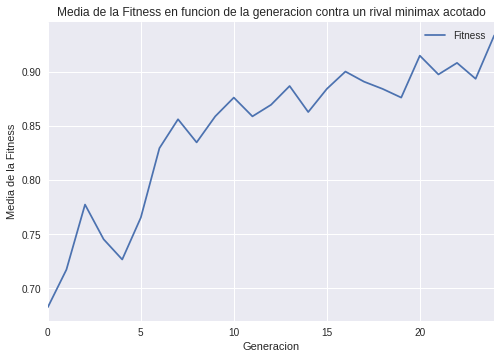

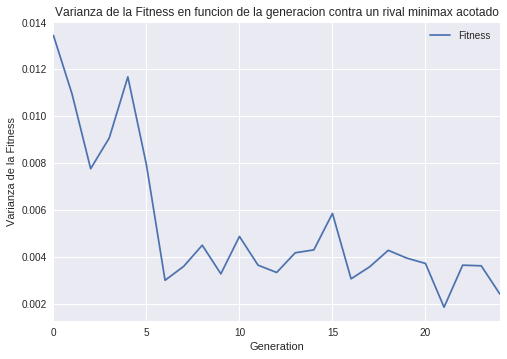

In [8]:
graphFitness('./fitness_MIXED_population25.txt',True,"minimax acotado")